In [1]:
import keras
import numpy as np
import pretty_midi
import librosa
import glob
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from train_util_e import NoteIsoSequence
from train_util_e import get_encoder, get_decoder, get_discriminator
from train_util_e import program_map, one_hot_map
import time

# synthesize without label and then add back for train?
# loud not at the end to force normalization?

Using TensorFlow backend.


In [2]:
midi_root_dir = "/home/faraaz/workspace/music-transcription/data/clean_midi/"
midi_files = glob.iglob(os.path.join(midi_root_dir, '**', '*.mid'))
midi_file = next(midi_files)
print(midi_file)

/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.mid


In [3]:
sf2_path="/usr/share/sounds/sf2/FluidR3_GM.sf2"
sample_rate = 32000
sample_duration = 2 * sample_rate
n_fft = 2048
epsilon = 0.00001
batch_size = 4
pm = pretty_midi.PrettyMIDI(midi_file)
pm_samples = pm.fluidsynth(fs=sample_rate, sf2_path=sf2_path)

In [4]:
instr_id = 0
note_id = 0
instrument = pm.instruments[instr_id]
print(instrument.notes[note_id])
note = instrument.notes[note_id]
sample_start = int(note.start * sample_rate)

Note(start=51.199077, end=51.318123, pitch=81, velocity=105)


In [5]:
padded_samples = pm_samples[:]
if len(padded_samples > sample_start+sample_duration):
    print("hi")
    print(pm_samples.shape)
    padded_samples = padded_samples[sample_start:sample_start+sample_duration]
if len(padded_samples) < sample_duration:
    padded_samples = np.pad(padded_samples, (0, sample_duration-len(padded_samples)), 
                                'constant', constant_values=(0,0))

hi
(10043769,)


In [6]:
print(padded_samples.shape)
print(padded_samples[-1])
ipd.Audio(padded_samples, rate=sample_rate)

(64000,)
-0.045230574857864816


(1025, 126)
(0.011267444+0j)


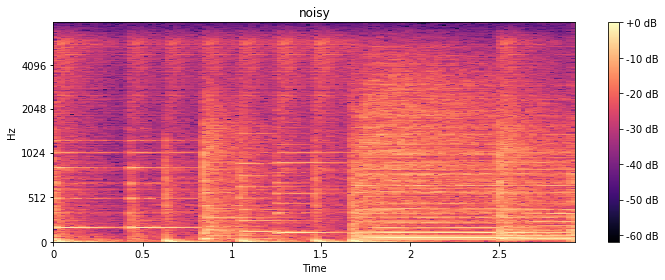

In [7]:
noisy_stft = librosa.core.stft(y=padded_samples, n_fft=n_fft)
print(noisy_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(noisy_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()
print(noisy_stft[-1][-1])

In [8]:
final_noisy = np.stack((noisy_stft.real, noisy_stft.imag), axis=2)
print(final_noisy.shape)

(1025, 126, 2)


In [9]:
annotation = np.zeros((1, final_noisy.shape[1], final_noisy.shape[2]))
print(annotation.shape)
annotation[0,0,0] = note.pitch
annotation[0,0,1] = note.end - note.start
final_input = np.append(final_noisy, annotation, axis=0)
print(final_input.shape)

(1, 126, 2)
(1026, 126, 2)


In [10]:
velocity = 96
pitch = 60
duration = 1
pm_iso = pretty_midi.PrettyMIDI()
iso_instrument = pretty_midi.Instrument(instrument.program, is_drum=False)
iso_note = pretty_midi.Note(velocity, pitch, 0, duration)
iso_instrument.notes = [iso_note]
pm_iso.instruments = [iso_instrument]

pm_iso_samples = pm_iso.fluidsynth(fs=sample_rate, sf2_path=sf2_path)
if len(pm_iso_samples) > sample_duration:
    pm_iso_samples = pm_iso_samples[:sample_duration]
if len(pm_iso_samples) < sample_duration:
    pm_iso_samples = np.pad(pm_iso_samples, (0, sample_duration-len(pm_iso_samples)), 
                            'constant', constant_values=(0,0))

ipd.Audio(pm_iso_samples, rate=sample_rate)

(1025, 126)


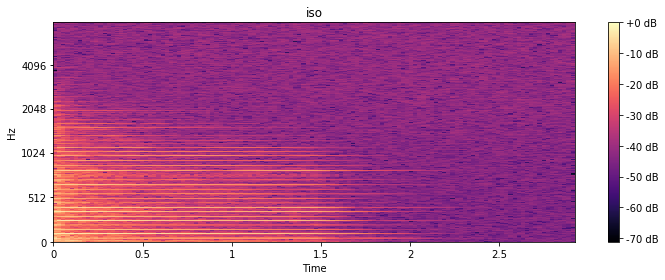

In [11]:
iso_stft = librosa.core.stft(y=pm_iso_samples, n_fft=n_fft)
print(iso_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(iso_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('iso')
plt.tight_layout()

In [12]:
# convert complex numbers to magnitude and phase
magnitude = np.abs(iso_stft)
phase = np.angle(iso_stft)
log_magnitude = np.log(magnitude)
magnitude_scale_factor = max(np.abs(np.amin(log_magnitude)), np.amax(log_magnitude)) + epsilon
scaled_magnitude = log_magnitude / magnitude_scale_factor
print("mag scale factor {}".format(magnitude_scale_factor))
scaled_phase = phase / (np.pi + epsilon)

print("mag unscaled [{}, {}]".format(np.amin(magnitude), np.amax(magnitude)))
print("mag scaled [{}, {}]".format(np.amin(scaled_magnitude), np.amax(scaled_magnitude)))
print("phase unscaled [{}, {}]".format(np.amin(phase), np.amax(phase)))
print("phase scaled [{}, {}]".format(np.amin(scaled_phase), np.amax(scaled_phase)))

final_iso = np.stack((magnitude, phase), axis=2)
print(final_iso.shape)

rev_magnitude = np.exp(scaled_magnitude * magnitude_scale_factor)
assert np.allclose(magnitude, rev_magnitude)
rev_phase = scaled_phase * (np.pi + epsilon)
assert np.allclose(phase, rev_phase)

rev_iso = magnitude * np.exp(1j*phase)
assert iso_stft.shape == rev_iso.shape
assert np.allclose(iso_stft, rev_iso)

final_iso = final_iso[:-1, :, :]  # shape (1024, 126, 2)
print(final_iso.shape)
final_iso_pad = np.zeros((1024, 2, 2))
final_iso = np.concatenate((final_iso, final_iso_pad), axis=1)  # shape (1024, 128, 2)
print(final_iso.shape)

mag scale factor 11.41000412536621
mag unscaled [1.1084148354711942e-05, 143.81735229492188]
mag scaled [-0.9999991655349731, 0.4354550838470459]
phase unscaled [-3.1415927410125732, 3.1415927410125732]
phase scaled [-0.9999968409538269, 0.9999968409538269]
(1025, 126, 2)
(1024, 126, 2)
(1024, 128, 2)


In [13]:
song_indices = [0]*64*40
instr_indices = [0]*64*40
note_indices = [0]*64*40 #list(range(4))*16*1
train_generator = NoteIsoSequence([midi_file], sample_duration=sample_duration, 
                                  fs=sample_rate, n_fft=n_fft, batch_size=batch_size,
                                  epsilon=epsilon, song_indices=song_indices, 
                                  instr_indices=instr_indices, note_indices=note_indices)

In [14]:
# discriminator = get_discriminator()
# discriminator.summary()
epochs = 10
workers = 1
use_multiprocessing = False
fake_labels = np.zeros((batch_size, 1))
real_labels = np.ones((batch_size, 1))

encoder = get_encoder()
decoder = get_decoder()
discriminator = get_discriminator()
# discriminator.summary()

adam = keras.optimizers.Adam(lr=0.01)
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
n_disc_trainable = len(discriminator.trainable_weights)

noisy_spectrogram = keras.layers.Input(shape=(1024, 128, 2))

latent_instr = encoder(noisy_spectrogram)
reconstructed_instr = decoder(latent_instr)

discriminator.trainable = False
predicted_instr = discriminator(reconstructed_instr)

autoencoder = keras.models.Model(noisy_spectrogram, reconstructed_instr)
n_gen_trainable = len(autoencoder.trainable_weights)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

combined = keras.models.Model(noisy_spectrogram, predicted_instr)
combined.compile(loss='binary_crossentropy', optimizer=adam)
combined.summary()

assert(len(discriminator._collected_trainable_weights) == n_disc_trainable)
assert(len(combined._collected_trainable_weights) == n_gen_trainable)
assert(len(autoencoder._collected_trainable_weights) == n_gen_trainable)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1024, 128, 2)      0         
_________________________________________________________________
model_1 (Model)              (None, 256)               6818592   
_________________________________________________________________
model_2 (Model)              (None, 1024, 128, 2)      6211786   
_________________________________________________________________
model_3 (Model)              (None, 1)                 4729377   
Total params: 17,759,755
Trainable params: 13,029,622
Non-trainable params: 4,730,133
_________________________________________________________________


In [15]:
# generator gives X, y each with shape [batch_size, 1024, 128, 2]
start = time.time()
for epoch in range(epochs):
    for i in range(len(train_generator)):
        X, y = train_generator[i]
        
        # train the discriminator
        fake_instr = autoencoder.predict(X)
        real_instr = y
        
        d_loss_real = discriminator.train_on_batch(real_instr, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_instr, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # reconstruct the correct output
        r_loss = autoencoder.train_on_batch(X, y)
        # trick the discriminator
        c_loss = combined.train_on_batch(X, real_labels)
        
        # option to save generated spectrograms at set intervals 
        if i == 0:
            print("[Dr: {}, {}; Df: {}, {}] [R: {}] [C: {}] {}s".format(
                d_loss_real[0], d_loss_real[1], d_loss_fake[0], d_loss_fake[1], 
                r_loss, c_loss, time.time()-start))
            print(discriminator.get_weights()[0][0][0][0][:5])
            print(combined.get_weights()[0][0][0][0][:5])
            start = time.time()

/home/faraaz/anaconda3/envs/urop/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Dr: 0.6922432780265808, 1.0; Df: 15.942384719848633, 0.0] [R: 0.5168065428733826] [C: 1.192093321833454e-07] 16.571127891540527s
[ 0.25656995 -0.13077644 -0.25048196  0.14353853  0.23120233]
[-0.24346906  0.00370703 -0.12927541  0.21841478 -0.18237777]


KeyboardInterrupt: 

In [ ]:
# print("loading model")
# model = keras.models.load_model('draft-4-b.h')

In [ ]:
instr_indices = [0]
note_indices = [0]
song_indices = [0]
test_generator = NoteIsoSequence([midi_file], sample_duration=sample_duration, 
                                 fs=sample_rate, n_fft=n_fft, instr_indices=instr_indices,
                                 note_indices=note_indices, song_indices=song_indices, batch_size=1)
predicted_iso = autoencoder.predict_generator(test_generator, steps=1)[0]
print(predicted_iso.shape)

In [ ]:
print(np.amin(predicted_iso))
print(np.amax(predicted_iso))
print(np.count_nonzero(np.isnan(predicted_iso)))
print(np.count_nonzero(np.abs(predicted_iso[:,:,1]) == 1))
predicted_iso *= 1 - epsilon
predicted_magnitude = np.exp(predicted_iso[:,:,0] * magnitude_scale_factor)
predicted_phase = predicted_iso[:,:,1] * (np.pi + epsilon)
predicted_stft = predicted_magnitude * np.exp(1j*predicted_phase)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(predicted_magnitude, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('predicted')
plt.tight_layout()

In [ ]:
predicted_audio = librosa.core.istft(predicted_stft)
ipd.Audio(predicted_audio, rate=sample_rate)

In [ ]:
print(np.amin(predicted_magnitude))
print(np.amax(predicted_magnitude))
print(np.amin(predicted_phase))
print(np.amax(predicted_phase))
print(predicted_iso[-1,-1,:])